# Klasszikus architektúrák

Megvizsgáltuk tehát hogy a konvolúciós architektúrák kisebb paraméterszámmal ugyanakkor nagyobb teljesítménnyel, tehát szignifikánsan jobb hatékonysággal működnek képi klasszifikáció esetén mint a teljesen összekötött rétegekből készített neurális hálózatok.

Felmerülhet kérdésként, hogy mi az ideális architektúra egy adott probléma megoldására: erre azonban nem könnyű felelni, ugyanis függ az adatok eloszlásától, mennyiségétől, felbontásától, a képek minőségétől, és a sort hosszan lehet folytatni...

Az elmúlt évek során többféle struktúrát publikáltak a kutatók, ezekből néhány általános ökölszabályt figyelhetünk meg, melyeket korábban alkalmaztunk is: Pooling esetén a maximális érték használata célszerű, ReLU aktivációk mellett, a konvolúciós kernelek mérete legyen lehetőség szerint minél kisebb, a filterszám pedig a mélyebb rétegekben lehetőség szerint egyre növekedjen.

Felmerülhet ötletként, hogy esetleg egy ismert architektúrát használjunk fel, például a korábban bemutatott ILSVRC díjnyertes modelljei alapján.

Oldjuk meg a korábbi Cats vs Dogs problémát ismert architektúrákkal!

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

imsize = 224

train_gen = ImageDataGenerator(rescale=1./255, 
                               featurewise_std_normalization=True)

train_data = train_gen.flow_from_directory("catsvsdogs\\training_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                          )

test_gen = ImageDataGenerator(rescale=1./255, featurewise_std_normalization=True)

test_data = train_gen.flow_from_directory("catsvsdogs\\test_set",
                                           target_size=(imsize, imsize),
                                           class_mode='binary',
                                           #batch_size=16
                                           batch_size=8
                                         )

A jól ismert VGG-16 modell jó eredményeket ért el, esetleg felépíthetjük ezt:

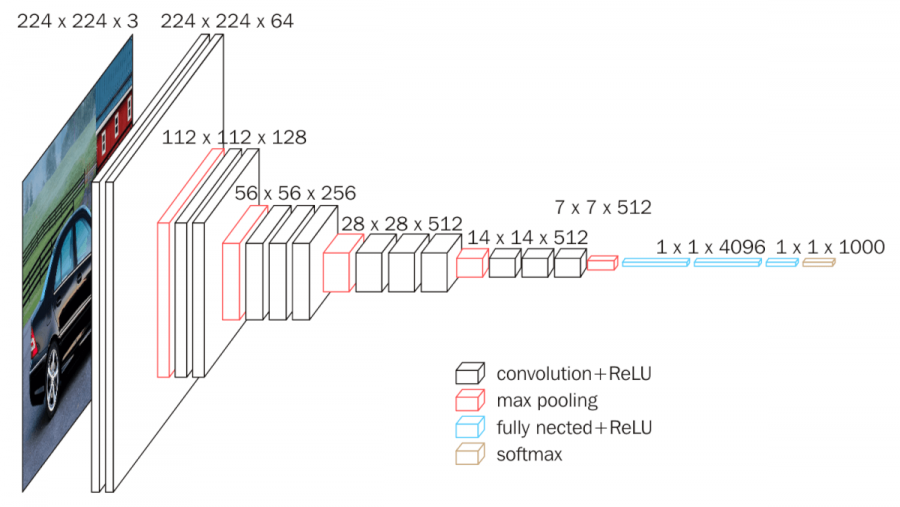

A Keras egyik nagy segítsége a fejlesztők felé, hogy nem kell újra fetalálni a kereket -- vagy legalábbis nem kell újra implementálni:

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16(include_top=True, weights=None, classes=1)

Konstruktorban megadjuk, hogy a "felső" input réteget is szeretnénk alkalmazni, előre betanított súlyokat nem szeretnénk betölteni (az ImageNet ILSVRC paraméterek betöltésére lenne lehetőség). A kimeneti osztályok száma $1$; hisz valójában bináris klasszifikátort építünk.

In [ ]:
model.summary()

A 134 millió paraméter rettentő sok: ha nem áll rendelkezésre GPU, akkor a tanítás folyamata nagyon lassú lesz. Erre az esetre lehetőség van kisebb paraméterszámú architektúrát is használni, például az itt bemutatott MobileNetv2 mindössze 2 millió tanítható paraméterből áll.

Ha van rendelkezésre álló GPU, ezeket a sorokat célszerű kihagyni!

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(include_top=True, weights=None, classes=1)

In [ ]:
model.summary()

Az utolsó rétegnél módostásokat kell eszközölni, hisz ez a modell eredetileg többosztályú klasszifikációra van, így az utolsó réteg aktivációja softmax:

In [ ]:
model.layers[-1].activation

Mivel a Cats vs Dogs alapból bináris klasszifikációként értelmezett, ezt állítsuk át sigmoidra!

In [ ]:
from keras.activations import sigmoid

model.layers[-1].activation = sigmoid

In [ ]:
model.layers[-1].activation

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import TensorBoard

tbcb = TensorBoard(log_dir="./logs/MobileNetV2-default")

In [ ]:
model.fit_generator(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=[tbcb]
                   )

Az eredmények láttán azért nem ájultunk el: látjuk ugyan hogy működik, de ez az architektúra nem erre a problémára lett kitalálva, hanem töbosztályú klasszifikációra az ImageNet 1000 osztályán.